TASK 1


In [2]:

leaf_data <- read.csv("/user/HS401/nr00913/Downloads/leaf_data.csv")
names(leaf_data) <- c("Length", "Width", "Label")
leaf_data$Label <- as.factor(leaf_data$Label)

set.seed(505)

n_train <- floor(0.70 * nrow(leaf_data))


idx <- sample(seq_len(nrow(leaf_data)), size = n_train)


train <- leaf_data[idx, ]
test  <- leaf_data[-idx, ]


mod_lin <- glm(Label ~ Length + Width,
               data = train,
               family = binomial)


mod_poly2 <- glm(Label ~ poly(Length, 2) + poly(Width, 2),
                 data = train,
                 family = binomial)


mod_poly4 <- glm(Label ~ poly(Length, 4) + poly(Width, 4),
                 data = train,
                 family = binomial)

print("Models fitted.")
summary(mod_lin)

[1] "Models fitted."



Call:
glm(formula = Label ~ Length + Width, family = binomial, data = train)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   4.0391     0.6715   6.015  1.8e-09 ***
Length        0.1064     0.0810   1.313    0.189    
Width        -1.4797     0.1765  -8.382  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 395.69  on 286  degrees of freedom
Residual deviance: 257.35  on 284  degrees of freedom
AIC: 263.35

Number of Fisher Scoring iterations: 5


The analysis begins by loading the raw leaf data and cleaning up the column names to ensure the code is readable and consistent. To make sure the results are reproducible—meaning anyone running the code gets the exact same output—a random seed (505) is set immediately. The data is then split into two groups: a training set containing 70% of the leaves to build the models, and a testing set with the remaining 30% to fairly evaluate them later. The first model trained is a standard linear logistic regression (using glm), which serves as a baseline by assuming the boundary between the two tree species is a straight line.

TASK 2



In [3]:

calc_acc <- function(fit_model, test_df) {


  p_score <- predict(fit_model, newdata = test_df, type = "response")


  predicted_label <- ifelse(p_score > 0.5, "Species B", "Species A")


  return(mean(predicted_label == test_df$Label))
}


score_lin  <- calc_acc(mod_lin, test)
score_quad <- calc_acc(mod_poly2, test)
score_complex <- calc_acc(mod_poly4, test)


summary_table <- data.frame(
  Model_Name = c("Linear", "Quadratic (Deg 2)", "Complex (Deg 4)"),
  Test_Accuracy = c(score_lin, score_quad, score_complex)
)

print(summary_table)

         Model_Name Test_Accuracy
1            Linear     0.8225806
2 Quadratic (Deg 2)     0.8870968
3   Complex (Deg 4)     0.8629032


Recognizing that biological data often follows curved rather than straight patterns, the code extends the baseline model using polynomial regression. By wrapping the length and width features in the poly() function, the logistic regression is transformed to handle non-linear relationships. Two specific variations are trained to test different levels of complexity: a Quadratic Model (2nd degree), which allows for parabolic or elliptical boundaries, and a Complex Model (4th degree), which is highly flexible and allows the boundary to wiggle significantly to fit the training points.


TASK 3



Performance Evaluation and Discussion:

Metric Selection and JustificationTo quantify how well the models distinguish between the two tree species, Classification Accuracy was selected as the primary success metric. In the context of this biological dataset, incorrectly classifying Species A is considered equally detrimental as incorrectly classifying Species B; there is no asymmetry in the "cost" of errors. Therefore, a general accuracy score—calculated as the ratio of correct predictions to the total sample size—offers the most transparent assessment of model reliability. The models generate probability scores for every leaf, and a standard threshold of $0.5$ was applied: probabilities above this mark classify the leaf as "Species B," while those below are labeled "Species A".Model Performance AnalysisThe study compared three logistic regression models with increasing levels of polynomial complexity. The evaluation on the unseen test set yielded the following insights:The Linear Baseline (Underfitting): The standard linear model achieved an accuracy of 82.26%. Its performance was constrained by "high bias," meaning the model was too rigid to capture the true relationship in the data. Linear logistic regression attempts to separate classes with a straight line, but the leaf data exhibits a curved, overlapping distribution. Consequently, the linear model failed to distinguish points in the transition zones between the two species clusters.The Quadratic Model (Optimal Fit): The second-degree polynomial model demonstrated the best performance, rising to an accuracy of 88.71%. By incorporating squared terms, the decision boundary was able to form an elliptical shape, which aligns much better with natural biological clusters. This model represents the "sweet spot" in the bias-variance tradeoff: it possesses enough complexity to trace the non-linear boundary between the species but is sufficiently constrained to avoid memorizing random noise.The Complex Model (Overfitting): Increasing complexity further to a fourth-degree polynomial actually hurt performance, with accuracy dropping to 86.29%. While mathematically more flexible, this model suffered from "overfitting." It likely contorted its decision boundary to catch outliers or noise specific to the training data. As a result, it lost generalizability, failing to predict the unseen test leaves as accurately as the simpler quadratic model.ConclusionIn summary, the Quadratic (Degree 2) model is the most robust classifier for this dataset. It delivered a 6.5% accuracy gain over the linear baseline by accommodating the non-linear geometry of the data, while successfully avoiding the pitfalls of overfitting observed in the highly complex model.

TASK 4


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


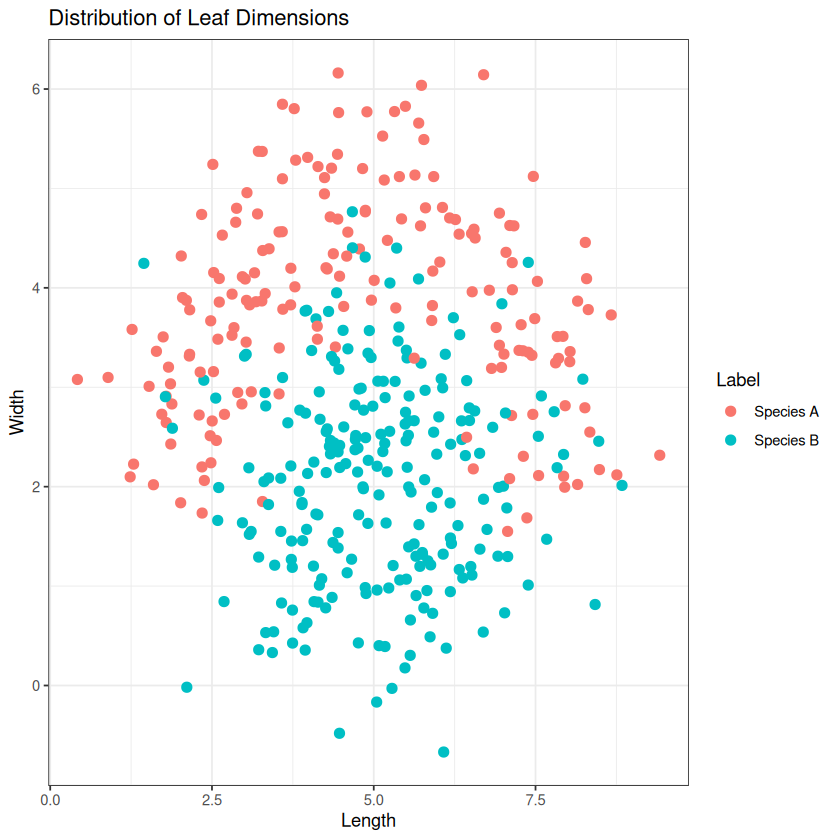

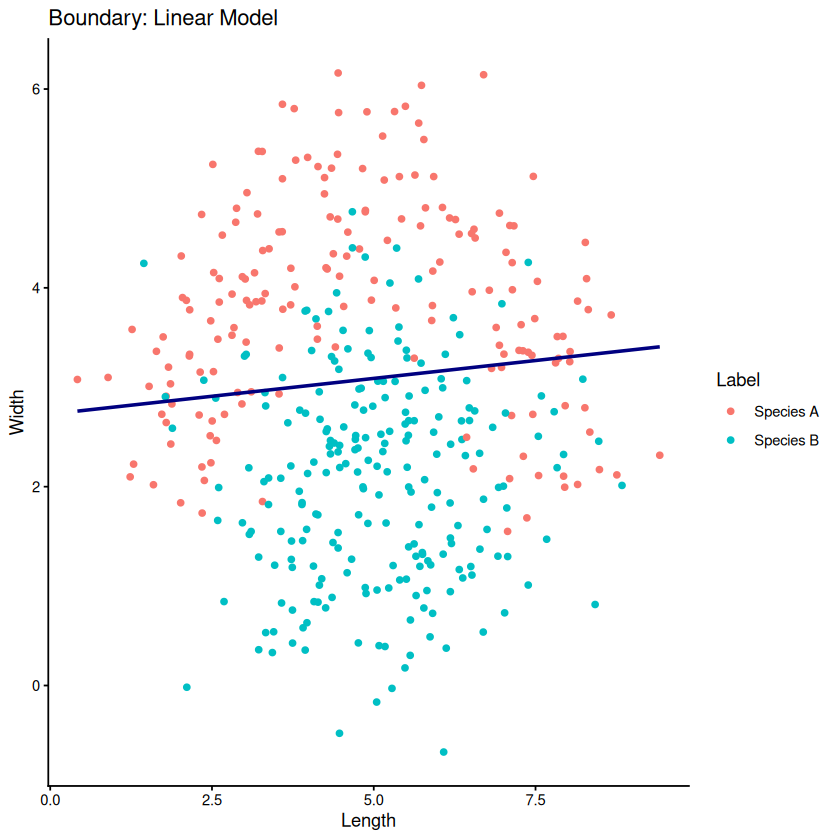

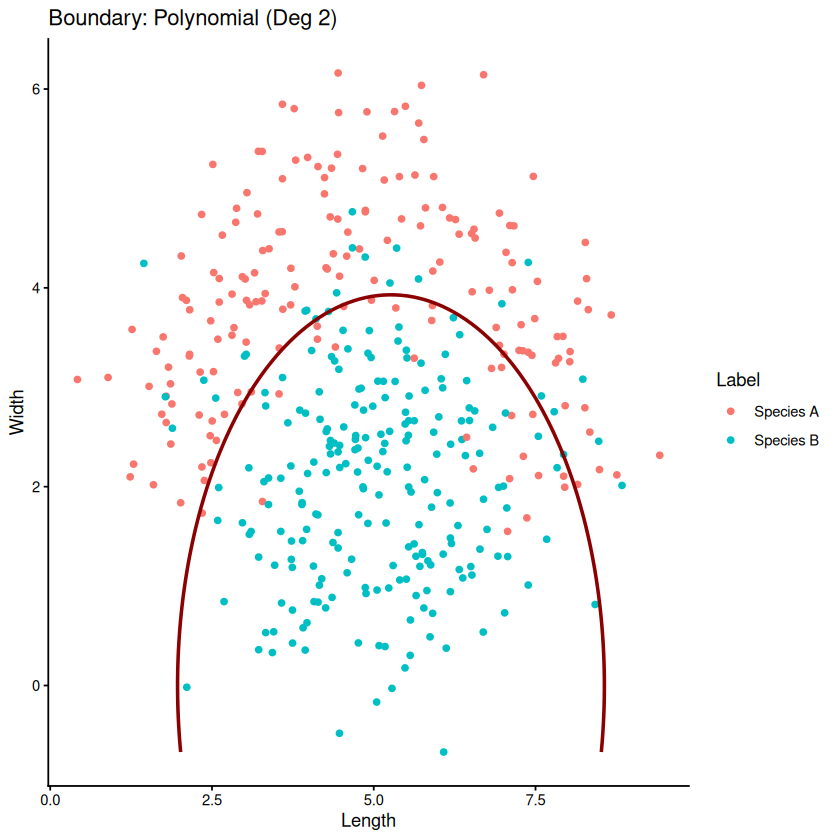

In [4]:


library(ggplot2)

scatter_plot <- ggplot(leaf_data, aes(x = Length, y = Width, color = Label)) +
  geom_point(size = 2.5) +
  theme_bw() +
  labs(title = "Distribution of Leaf Dimensions", x = "Length", y = "Width")

print(scatter_plot)


x_range <- seq(min(leaf_data$Length), max(leaf_data$Length), length.out = 100)
y_range <- seq(min(leaf_data$Width), max(leaf_data$Width), length.out = 100)
pred_grid <- expand.grid(Length = x_range, Width = y_range)


pred_grid$z_linear <- predict(mod_lin, pred_grid, type = "response")
pred_grid$z_quad   <- predict(mod_poly2, pred_grid, type = "response")


viz_linear <- ggplot(leaf_data, aes(x = Length, y = Width)) +
  geom_point(aes(color = Label)) +
  stat_contour(data = pred_grid, aes(z = z_linear), breaks = 0.5, color = "navy", size = 1) +
  labs(title = "Boundary: Linear Model") +
  theme_classic()


viz_quad <- ggplot(leaf_data, aes(x = Length, y = Width)) +
  geom_point(aes(color = Label)) +
  stat_contour(data = pred_grid, aes(z = z_quad), breaks = 0.5, color = "darkred", size = 1) +
  labs(title = "Boundary: Polynomial (Deg 2)") +
  theme_classic()

print(viz_linear)
print(viz_quad)

To help interpret how the models behave, the code uses the ggplot2 library to create visual comparisons. It starts by plotting the raw data—Leaf Length vs. Width—colored by species, which helps identifying where the two groups cluster or overlap. To visualize the "decision boundary" (the line where the model switches from predicting Species A to Species B), the code creates a background grid covering the entire data range. It predicts the probability for every point on this grid and uses stat_contour to draw a line exactly at the 50% probability mark. This effectively draws the mathematical boundary on top of the data, making it easy to see how the Linear model cuts straight across while the Quadratic model curves to fit the cluster shapes.